In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Output')

library("readxl")
library(tidyverse)
library(reshape2)
library(car) #package necessary to run anova and specify type III errors
library("multcomp") #for Tukey's post hoc
library(rstatix)

#reading in file
data <- read_excel("CytokineData_102920.xlsx", sheet = 2)
data_df = data.frame(data)

#reading in demographics file
demographics_data_df = data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: mvtnorm

Warning message:
“package ‘mvtnorm’ was built under R version 4.0.3”
Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching packa

In [2]:
#adding demographics data to cytokine df
#could've made my life easier by just using full_join but didn't need every column from the demographics data set
race = c()
ethnicity = c()
sex = c()
age = c()
BMI = c()
for (i in 1:length(data_df$SubjectNo)){
    for(j in 1:length(demographics_data_df$SubjectNo)){
        if (data_df$SubjectNo[i] == demographics_data_df$SubjectNo[j]){
            race = c(race, demographics_data_df$Race[j])
            ethnicity = c(ethnicity, demographics_data_df$Ethnicity[j])
            sex = c(sex, demographics_data_df$Sex[j])
            age = c(age, demographics_data_df$Age[j])
            BMI = c(BMI, demographics_data_df$BMI[j])
        }
    }
}

data_df$Race = race
data_df$Ethnicity = ethnicity
data_df$Sex = sex
data_df$Age = age
data_df$BMI = BMI

First running "crude" model by running ANOVA to compare cytokine profiles across compartments. Then running ANCOVA to compare cytokine profiles across compartments adjusting for race and sex separately. Z-score normalizing for  cytokines (using pseudolog2 transformed concentrations).

In [3]:
head(data_df)

,Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID,Race,Ethnicity,Sex,Age,BMI
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,E_C_F_002,IFNg,17.642316,4.220509,ELF,1,NS,NS_1,W,NH,F,28,37.67
2,E_C_F_002,IL10,2.873724,1.953721,ELF,1,NS,NS_1,W,NH,F,28,37.67
3,E_C_F_002,IL12p70,1.625272,1.392467,ELF,1,NS,NS_1,W,NH,F,28,37.67
4,E_C_F_002,IL13,36.117692,5.214035,ELF,1,NS,NS_1,W,NH,F,28,37.67
5,E_C_F_002,IL1b,104.409217,6.719857,ELF,1,NS,NS_1,W,NH,F,28,37.67
6,E_C_F_002,IL6,21.159536,4.469856,ELF,1,NS,NS_1,W,NH,F,28,37.67


In [4]:
#making race binary between black and non- black subjects
#making race binary between white and non-white subjects
for (i in 1:length(demographics_data_df$Race)){
    if(demographics_data_df$Race[i] != 'W'){
        demographics_data_df$Race[i] = 'NW'
    }
}

In [5]:
#scaling the concentration values by protein normalizes the distribution
scaled_data_df = data_df %>%
    filter(Group == 'NS') %>% #non-smokers only
    group_by(Protein) %>% #this groups by compartment first
    mutate(Scaled_Concentrations = scale(Conc_pslog2)) %>%
    arrange(Compartment, Protein, SubjectID) #arranges by compartment, then protein, then subjectid
head(scaled_data_df)

Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID,Race,Ethnicity,Sex,Age,BMI,Scaled_Concentrations
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,"<dbl[,1]>"
E_C_F_002,Eotaxin,147.64524,7.215729,ELF,1,NS,NS_1,W,NH,F,28,37.67,0.4682499
E_C_M_122,Eotaxin,257.88962,8.016193,ELF,10,NS,NS_10,W,NH,M,34,19.80,0.7153580
E_C_M_123,Eotaxin,75.86487,6.264252,ELF,11,NS,NS_11,W,NH,M,24,26.10,0.1745230
E_C_M_130,Eotaxin,121.64497,6.938344,ELF,12,NS,NS_12,W,NH,M,26,20.00,0.3826194
E_C_M_138,Eotaxin,34.57231,5.152683,ELF,13,NS,NS_13,W,H,M,39,36.80,-0.1686254
E_C_M_140,Eotaxin,244.21306,7.937892,ELF,14,NS,NS_14,W,NH,M,31,29.70,0.6911859


In [6]:
# creating a df for each cytokine individually
Eotaxin_scaled = scaled_data_df %>% filter(Protein == 'Eotaxin')
Eotaxin3_scaled = scaled_data_df %>% filter(Protein == 'Eotaxin3')
Fractalkine_scaled = scaled_data_df %>% filter(Protein == 'Fractalkine')
I309_scaled = scaled_data_df %>% filter(Protein == 'I309')
IFNg_scaled = scaled_data_df %>% filter(Protein == 'IFNg')
IL10_scaled = scaled_data_df %>% filter(Protein == 'IL10')
IL12p70_scaled = scaled_data_df %>% filter(Protein == 'IL12p70')
IL13_scaled = scaled_data_df %>% filter(Protein == 'IL13')
IL17B_scaled = scaled_data_df %>% filter(Protein == 'IL17B')
IL17D_scaled = scaled_data_df %>% filter(Protein == 'IL17D')
IL1b_scaled = scaled_data_df %>% filter(Protein == 'IL1b')
IL4_scaled = scaled_data_df %>% filter(Protein == 'IL4')
IL6_scaled = scaled_data_df %>% filter(Protein == 'IL6')
IL8_scaled = scaled_data_df %>% filter(Protein == 'IL8')
IP10_scaled = scaled_data_df %>% filter(Protein == 'IP10')
ITAC_scaled = scaled_data_df %>% filter(Protein == 'ITAC')
MCP1_scaled = scaled_data_df %>% filter(Protein == 'MCP1')
MIG_scaled = scaled_data_df %>% filter(Protein == 'MIG')
MIP1a_scaled = scaled_data_df %>% filter(Protein == 'MIP1a')
MIP1b_scaled = scaled_data_df %>% filter(Protein == 'MIP1b')
TARC_scaled = scaled_data_df %>% filter(Protein == 'TARC')
TNFa_scaled = scaled_data_df %>% filter(Protein == 'TNFa')

## One-way Anova

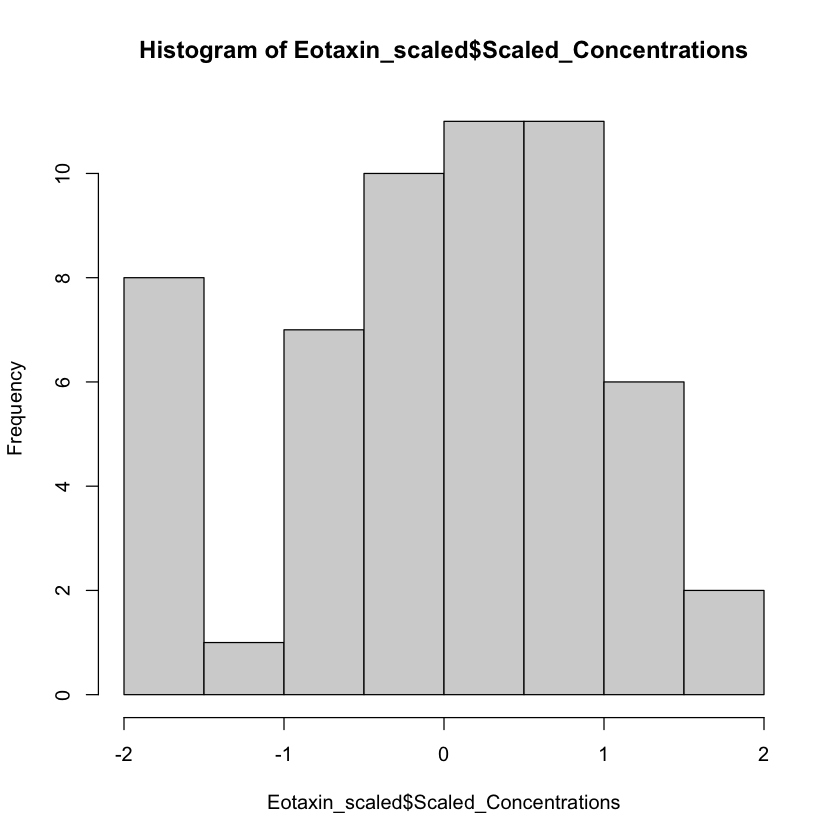

In [7]:
#checking for normal distribution
hist(Eotaxin_scaled$Scaled_Concentrations)

In [8]:
#formatting data to be put into the anova function 
change_data_types = function(scaled_df){
    #making compartment and covariates into factors
    scaled_df$Compartment = factor(scaled_df$Compartment, labels = c(unique(scaled_df$Compartment)))
    scaled_df$Race = factor(scaled_df$Race, labels = c(unique(scaled_df$Race)))
    
    #making scaled_concentrations col into a numeric
    scaled_df$Scaled_Concentrations = as.numeric(scaled_df$Scaled_Concentrations)
    return(scaled_df)
}

#calling fn
Eotaxin_scaled_factored = change_data_types(Eotaxin_scaled)
Eotaxin3_scaled_factored = change_data_types(Eotaxin3_scaled)
Fractalkine_scaled_factored = change_data_types(Fractalkine_scaled)
I309_scaled_factored = change_data_types(I309_scaled)
IFNg_scaled_factored = change_data_types(IFNg_scaled)
IL10_scaled_factored = change_data_types(IL10_scaled)
IL12p70_scaled_factored = change_data_types(IL12p70_scaled)
IL13_scaled_factored = change_data_types(IL13_scaled)
IL17B_scaled_factored = change_data_types(IL17B_scaled)
IL17D_scaled_factored = change_data_types(IL17D_scaled)
IL1b_scaled_factored = change_data_types(IL1b_scaled)
IL4_scaled_factored = change_data_types(IL4_scaled)
IL6_scaled_factored = change_data_types(IL6_scaled)
IL8_scaled_factored = change_data_types(IL8_scaled)
IP10_scaled_factored = change_data_types(IP10_scaled)
ITAC_scaled_factored = change_data_types(ITAC_scaled)
MCP1_scaled_factored = change_data_types(MCP1_scaled)
MIG_scaled_factored = change_data_types(MIG_scaled)
MIP1a_scaled_factored = change_data_types(MIP1a_scaled)
MIP1b_scaled_factored = change_data_types(MIP1b_scaled)
TARC_scaled_factored = change_data_types(TARC_scaled)
TNFa_scaled_factored = change_data_types(TNFa_scaled)

In [9]:
#contrasts show what compartments are being compared in anova
#these comparisons aren't what we want so I changed them in the function below
contrasts(Eotaxin_scaled_factored$Compartment)

,NLF,Serum,Sputum
ELF,0,0,0
NLF,1,0,0
Serum,0,1,0
Sputum,0,0,1


                      Table of Contrasts
>                 NLF (Baseline) | ELF | Sputum | Serum | Sum
>     Contrast 1 |         -3    |  1  |   1    |   1   |  0
>     Contrast 2 |         0     | -2  |   1    |   1   |  0
>     Contrast 3 |         0     |  0  |   -1   |   1   |  0

> - Contrast 1: compares NLF to all other compartments
> - Contrast 2: compares ELF to Sputum, Serum
> - Contrast 3: compares Sputum to Serum

In [10]:
get_anova = function(scaled_df){
    contrasts(scaled_df$Compartment) = cbind(c(1,-3,1,1),c(-2,0,1,1), c(0,0,-1,1)) #meaning is specified above
    anova = aov(Scaled_Concentrations~Compartment, data = scaled_df)
    return(anova)
}

#calling fn
Eotaxin_anova = get_anova(Eotaxin_scaled_factored)
Eotaxin3_anova = get_anova(Eotaxin3_scaled_factored)
Fractalkine_anova = get_anova(Fractalkine_scaled_factored)
I309_anova = get_anova(I309_scaled_factored)
IFNg_anova = get_anova(IFNg_scaled_factored)
IL10_anova = get_anova(IL10_scaled_factored)
IL12p70_anova = get_anova(IL12p70_scaled_factored)
IL13_anova = get_anova(IL13_scaled_factored)
IL17B_anova = get_anova(IL17B_scaled_factored)
IL17D_anova = get_anova(IL17D_scaled_factored)
IL1b_anova = get_anova(IL1b_scaled_factored)
IL4_anova = get_anova(IL4_scaled_factored)
IL6_anova = get_anova(IL6_scaled_factored)
IL8_anova = get_anova(IL8_scaled_factored)
IP10_anova = get_anova(IP10_scaled_factored)
ITAC_anova = get_anova(ITAC_scaled_factored)
MCP1_anova = get_anova(MCP1_scaled_factored)
MIG_anova = get_anova(MIG_scaled_factored)
MIP1a_anova = get_anova(MIP1a_scaled_factored)
MIP1b_anova = get_anova(MIP1b_scaled_factored)
TARC_anova = get_anova(TARC_scaled_factored)
TNFa_anova = get_anova(TNFa_scaled_factored)

In [11]:
#viewing results
summary(Eotaxin_anova) 
summary(Eotaxin3_anova)
summary(Fractalkine_anova) 
summary(I309_anova) 
summary(IFNg_anova) 
summary(IL10_anova) 
summary(IL12p70_anova) 
summary(IL13_anova) 
summary(IL17B_anova) 
summary(IL17D_anova) 
summary(IL1b_anova) 
summary(IL4_anova) 
summary(IL6_anova) 
summary(IL8_anova)
summary(IP10_anova) 
summary(ITAC_anova) 
summary(MCP1_anova) 
summary(MIG_anova) 
summary(MIP1a_anova) 
summary(MIP1b_anova) 
summary(TARC_anova) 
summary(TNFa_anova) 

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  41.07  13.689   51.08 1.59e-15 ***
Residuals   52  13.93   0.268                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)   
Compartment  3  13.51   4.504   5.646  0.002 **
Residuals   52  41.49   0.798                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  30.94  10.313   22.29 2.05e-09 ***
Residuals   52  24.06   0.463                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)   
Compartment  3  13.23   4.410   5.491 0.00236 **
Residuals   52  41.77   0.803                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  41.85  13.951   55.18 3.55e-16 ***
Residuals   52  13.15   0.253                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  38.79  12.929   41.47 7.96e-14 ***
Residuals   52  16.21   0.312                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  21.31   7.105   10.97 1.09e-05 ***
Residuals   52  33.69   0.648                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  15.04   5.014   6.525 0.000789 ***
Residuals   52  39.96   0.768                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  19.16   6.387   9.267 5.19e-05 ***
Residuals   52  35.84   0.689                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)  
Compartment  3   8.63  2.8775   3.227 0.0298 *
Residuals   52  46.37  0.8917                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  43.13  14.375   62.95 <2e-16 ***
Residuals   52  11.87   0.228                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  43.55   14.52   65.89 <2e-16 ***
Residuals   52  11.45    0.22                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)   
Compartment  3  14.52   4.838   6.215 0.00109 **
Residuals   52  40.48   0.779                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3   45.2  15.067   79.97 <2e-16 ***
Residuals   52    9.8   0.188                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)
Compartment  3   5.97  1.9910   2.112   0.11
Residuals   52  49.03  0.9428               

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  19.35   6.451    9.41 4.54e-05 ***
Residuals   52  35.65   0.686                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  45.94  15.314   87.92 <2e-16 ***
Residuals   52   9.06   0.174                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)    
Compartment  3  18.27   6.091   8.624 9.6e-05 ***
Residuals   52  36.73   0.706                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  24.09   8.029   13.51 1.23e-06 ***
Residuals   52  30.91   0.594                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)    
Compartment  3  38.27  12.755   39.63 1.8e-13 ***
Residuals   52  16.73   0.322                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  49.84  16.615   167.6 <2e-16 ***
Residuals   52   5.16   0.099                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  39.82  13.273   45.47 1.46e-14 ***
Residuals   52  15.18   0.292                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

All of these yielded statistically significant results except IP10. ANOVA tests only tell us if there are differences between groups (cytokines), but not which ones hence we need a Tukey's test for post hoc to do that.

In [12]:
# Tukey's post hoc
Eotaxin_tukey_anova = TukeyHSD(Eotaxin_anova, type = 'III')
Eotaxin3_tukey_anova = TukeyHSD(Eotaxin3_anova, type = 'III')
Fractalkine_tukey_anova = TukeyHSD(Fractalkine_anova, type = 'III')
I309_tukey_anova = TukeyHSD(I309_anova, type = 'III')
IFNg_tukey_anova = TukeyHSD(IFNg_anova, type = 'III')
IL10_tukey_anova = TukeyHSD(IL10_anova, type = 'III')
IL12p70_tukey_anova = TukeyHSD(IL12p70_anova, type = 'III')
IL13_tukey_anova = TukeyHSD(IL13_anova, type = 'III')
IL17B_tukey_anova = TukeyHSD(IL17B_anova, type = 'III')
IL17D_tukey_anova = TukeyHSD(IL17D_anova, type = 'III')
IL1b_tukey_anova = TukeyHSD(IL1b_anova, type = 'III')
IL4_tukey_anova = TukeyHSD(IL4_anova, type = 'III')
IL6_tukey_anova = TukeyHSD(IL6_anova, type = 'III')
IL8_tukey_anova = TukeyHSD(IL8_anova, type = 'III')
IP10_tukey_anova = TukeyHSD(IP10_anova, type = 'III')
ITAC_tukey_anova = TukeyHSD(ITAC_anova, type = 'III')
MCP1_tukey_anova = TukeyHSD(MCP1_anova, type = 'III')
MIG_tukey_anova = TukeyHSD(MIG_anova, type = 'III')
MIP1a_tukey_anova = TukeyHSD(MIP1a_anova, type = 'III')
MIP1b_tukey_anova = TukeyHSD(MIP1b_anova, type = 'III')
TARC_tukey_anova = TukeyHSD(TARC_anova, type = 'III')
TNFa_tukey_anova = TukeyHSD(TNFa_anova, type = 'III')

# ANCOVA

In [13]:
#controlling for race
get_ancova_race = function(scaled_df){
    contrasts(scaled_df$Compartment) = cbind(c(1,-3,1,1),c(-2,0,1,1), c(0,0,-1,1))
    ancova = aov(Scaled_Concentrations~Race+Compartment, data = scaled_df) 
    #anova_type3 = Anova(ancova, type = 'III')
    return(ancova)
}

#calling fn
Eotaxin_ancova_race = get_ancova_race(Eotaxin_scaled_factored)
Eotaxin3_ancova_race = get_ancova_race(Eotaxin3_scaled_factored)
Fractalkine_ancova_race = get_ancova_race(Fractalkine_scaled_factored)
I309_ancova_race = get_ancova_race(I309_scaled_factored)
IFNg_ancova_race = get_ancova_race(IFNg_scaled_factored)
IL10_ancova_race = get_ancova_race(IL10_scaled_factored)
IL12p70_ancova_race = get_ancova_race(IL12p70_scaled_factored)
IL13_ancova_race = get_ancova_race(IL13_scaled_factored)
IL17B_ancova_race = get_ancova_race(IL17B_scaled_factored)
IL17D_ancova_race = get_ancova_race(IL17D_scaled_factored)
IL1b_ancova_race = get_ancova_race(IL1b_scaled_factored)
IL4_ancova_race = get_ancova_race(IL4_scaled_factored)
IL6_ancova_race = get_ancova_race(IL6_scaled_factored)
IL8_ancova_race = get_ancova_race(IL8_scaled_factored)
IP10_ancova_race = get_ancova_race(IP10_scaled_factored)
ITAC_ancova_race = get_ancova_race(ITAC_scaled_factored)
MCP1_ancova_race = get_ancova_race(MCP1_scaled_factored)
MIG_ancova_race = get_ancova_race(MIG_scaled_factored)
MIP1a_ancova_race = get_ancova_race(MIP1a_scaled_factored)
MIP1b_ancova_race = get_ancova_race(MIP1b_scaled_factored)
TARC_ancova_race = get_ancova_race(TARC_scaled_factored)
TNFa_ancova_race = get_ancova_race(TNFa_scaled_factored)

In [14]:
#another way of doing ancova
posth = glht(aov(Scaled_Concentrations~Race+Compartment, data = Eotaxin_scaled_factored), linfct= mcp(Compartment = 'Tukey'))
summary(posth)


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = Scaled_Concentrations ~ Race + Compartment, data = Eotaxin_scaled_factored)

Linear Hypotheses:
                    Estimate Std. Error t value Pr(>|t|)    
NLF - ELF == 0       -0.7475     0.1937  -3.859  0.00190 ** 
Serum - ELF == 0      0.6954     0.1937   3.590  0.00411 ** 
Sputum - ELF == 0    -1.6056     0.1937  -8.290  < 0.001 ***
Serum - NLF == 0      1.4429     0.1937   7.449  < 0.001 ***
Sputum - NLF == 0    -0.8581     0.1937  -4.430  < 0.001 ***
Sputum - Serum == 0  -2.3010     0.1937 -11.880  < 0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


In [15]:
# Tukey's post hoc
Eotaxin_tukey_ancova_race = TukeyHSD(Eotaxin_ancova_race, type = 'III')
Eotaxin3_tukey_ancova_race = TukeyHSD(Eotaxin3_ancova_race, type = 'III')
Fractalkine_tukey_ancova_race = TukeyHSD(Fractalkine_ancova_race, type = 'III')
I309_tukey_ancova_race = TukeyHSD(I309_ancova_race, type = 'III')
IFNg_tukey_ancova_race = TukeyHSD(IFNg_ancova_race, type = 'III')
IL10_tukey_ancova_race = TukeyHSD(IL10_ancova_race, type = 'III')
IL12p70_tukey_ancova_race = TukeyHSD(IL12p70_ancova_race, type = 'III')
IL13_tukey_ancova_race = TukeyHSD(IL13_ancova_race, type = 'III')
IL17B_tukey_ancova_race = TukeyHSD(IL17B_ancova_race, type = 'III')
IL17D_tukey_ancova_race = TukeyHSD(IL17D_ancova_race, type = 'III')
IL1b_tukey_ancova_race = TukeyHSD(IL1b_ancova_race, type = 'III')
IL4_tukey_ancova_race = TukeyHSD(IL4_ancova_race, type = 'III')
IL6_tukey_ancova_race = TukeyHSD(IL6_ancova_race, type = 'III')
IL8_tukey_ancova_race = TukeyHSD(IL8_ancova_race, type = 'III')
IP10_tukey_ancova_race = TukeyHSD(IP10_ancova_race, type = 'III')
ITAC_tukey_ancova_race = TukeyHSD(ITAC_ancova_race, type = 'III')
MCP1_tukey_ancova_race = TukeyHSD(MCP1_ancova_race, type = 'III')
MIG_tukey_ancova_race = TukeyHSD(MIG_ancova_race, type = 'III')
MIP1a_tukey_ancova_race = TukeyHSD(MIP1a_ancova_race, type = 'III')
MIP1b_tukey_ancova_race = TukeyHSD(MIP1b_ancova_race, type = 'III')
TARC_tukey_ancova_race = TukeyHSD(TARC_ancova_race, type = 'III')
TNFa_tukey_ancova_race = TukeyHSD(TNFa_ancova_race, type = 'III')

In [16]:
#controlling for sex
get_ancova_sex = function(scaled_df){
    contrasts(scaled_df$Compartment) = cbind(c(1,-3,1,1),c(-2,0,1,1), c(0,0,-1,1)) #meaning is explained above
    ancova = aov(Scaled_Concentrations~Sex+Compartment, data = scaled_df)
    #anova_type3 = Anova(ancova, type = 'III')
    return(ancova)
}

#calling fn
Eotaxin_ancova_sex = get_ancova_sex(Eotaxin_scaled_factored)
Eotaxin3_ancova_sex = get_ancova_sex(Eotaxin3_scaled_factored)
Fractalkine_ancova_sex = get_ancova_sex(Fractalkine_scaled_factored)
I309_ancova_sex = get_ancova_sex(I309_scaled_factored)
IFNg_ancova_sex = get_ancova_sex(IFNg_scaled_factored)
IL10_ancova_sex = get_ancova_sex(IL10_scaled_factored)
IL12p70_ancova_sex = get_ancova_sex(IL12p70_scaled_factored)
IL13_ancova_sex = get_ancova_sex(IL13_scaled_factored)
IL17B_ancova_sex = get_ancova_sex(IL17B_scaled_factored)
IL17D_ancova_sex = get_ancova_sex(IL17D_scaled_factored)
IL1b_ancova_sex = get_ancova_sex(IL1b_scaled_factored)
IL4_ancova_sex = get_ancova_sex(IL4_scaled_factored)
IL6_ancova_sex = get_ancova_sex(IL6_scaled_factored)
IL8_ancova_sex = get_ancova_sex(IL8_scaled_factored)
IP10_ancova_sex = get_ancova_sex(IP10_scaled_factored)
ITAC_ancova_sex = get_ancova_sex(ITAC_scaled_factored)
MCP1_ancova_sex = get_ancova_sex(MCP1_scaled_factored)
MIG_ancova_sex = get_ancova_sex(MIG_scaled_factored)
MIP1a_ancova_sex = get_ancova_sex(MIP1a_scaled_factored)
MIP1b_ancova_sex = get_ancova_sex(MIP1b_scaled_factored)
TARC_ancova_sex = get_ancova_sex(TARC_scaled_factored)
TNFa_ancova_sex = get_ancova_sex(TNFa_scaled_factored)

In [17]:
#another way of doing ancova
posth2 = glht(aov(Scaled_Concentrations~Sex+Compartment, data = Eotaxin_scaled_factored), linfct= mcp(Compartment = 'Tukey'))
summary(posth2)


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = Scaled_Concentrations ~ Sex + Compartment, data = Eotaxin_scaled_factored)

Linear Hypotheses:
                    Estimate Std. Error t value Pr(>|t|)    
NLF - ELF == 0       -0.7475     0.1879  -3.977  0.00123 ** 
Serum - ELF == 0      0.6954     0.1879   3.700  0.00281 ** 
Sputum - ELF == 0    -1.6056     0.1879  -8.543  < 0.001 ***
Serum - NLF == 0      1.4429     0.1879   7.677  < 0.001 ***
Sputum - NLF == 0    -0.8581     0.1879  -4.566  < 0.001 ***
Sputum - Serum == 0  -2.3010     0.1879 -12.243  < 0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


In [18]:
# Tukey's post hoc
Eotaxin_tukey_ancova_sex = TukeyHSD(Eotaxin_ancova_sex, type = 'III')
Eotaxin3_tukey_ancova_sex = TukeyHSD(Eotaxin3_ancova_sex, type = 'III')
Fractalkine_tukey_ancova_sex = TukeyHSD(Fractalkine_ancova_sex, type = 'III')
I309_tukey_ancova_sex = TukeyHSD(I309_ancova_sex, type = 'III')
IFNg_tukey_ancova_sex = TukeyHSD(IFNg_ancova_sex, type = 'III')
IL10_tukey_ancova_sex = TukeyHSD(IL10_ancova_sex, type = 'III')
IL12p70_tukey_ancova_sex = TukeyHSD(IL12p70_ancova_sex, type = 'III')
IL13_tukey_ancova_sex = TukeyHSD(IL13_ancova_sex, type = 'III')
IL17B_tukey_ancova_sex = TukeyHSD(IL17B_ancova_sex, type = 'III')
IL17D_tukey_ancova_sex = TukeyHSD(IL17D_ancova_sex, type = 'III')
IL1b_tukey_ancova_sex = TukeyHSD(IL1b_ancova_sex, type = 'III')
IL4_tukey_ancova_sex = TukeyHSD(IL4_ancova_sex, type = 'III')
IL6_tukey_ancova_sex = TukeyHSD(IL6_ancova_sex, type = 'III')
IL8_tukey_ancova_sex = TukeyHSD(IL8_ancova_sex, type = 'III')
IP10_tukey_ancova_sex = TukeyHSD(IP10_ancova_sex, type = 'III')
ITAC_tukey_ancova_sex = TukeyHSD(ITAC_ancova_sex, type = 'III')
MCP1_tukey_ancova_sex = TukeyHSD(MCP1_ancova_sex, type = 'III')
MIG_tukey_ancova_sex = TukeyHSD(MIG_ancova_sex, type = 'III')
MIP1a_tukey_ancova_sex = TukeyHSD(MIP1a_ancova_sex, type = 'III')
MIP1b_tukey_ancova_sex = TukeyHSD(MIP1b_ancova_sex, type = 'III')
TARC_tukey_ancova_sex = TukeyHSD(TARC_ancova_sex, type = 'III')
TNFa_tukey_ancova_sex = TukeyHSD(TNFa_ancova_sex, type = 'III')

In [19]:
#controlling for age
get_ancova_age = function(scaled_df){
    #don't need anymore
    contrasts(scaled_df$Compartment) = cbind(c(1,-3,1,1),c(-2,0,1,1), c(0,0,-1,1)) #meaning is explained above
    ancova = aov(Scaled_Concentrations~Compartment+Age, data = scaled_df)
    #anova_type3 = Anova(ancova, type = 'III')
    return(ancova)
}

#calling fn
Eotaxin_ancova_age = get_ancova_age(Eotaxin_scaled_factored)
Eotaxin3_ancova_age = get_ancova_age(Eotaxin3_scaled_factored)
Fractalkine_ancova_age = get_ancova_age(Fractalkine_scaled_factored)
I309_ancova_age = get_ancova_age(I309_scaled_factored)
IFNg_ancova_age = get_ancova_age(IFNg_scaled_factored)
IL10_ancova_age = get_ancova_age(IL10_scaled_factored)
IL12p70_ancova_age = get_ancova_age(IL12p70_scaled_factored)
IL13_ancova_age = get_ancova_age(IL13_scaled_factored)
IL17B_ancova_age = get_ancova_age(IL17B_scaled_factored)
IL17D_ancova_age = get_ancova_age(IL17D_scaled_factored)
IL1b_ancova_age = get_ancova_age(IL1b_scaled_factored)
IL4_ancova_age = get_ancova_age(IL4_scaled_factored)
IL6_ancova_age = get_ancova_age(IL6_scaled_factored)
IL8_ancova_age = get_ancova_age(IL8_scaled_factored)
IP10_ancova_age = get_ancova_age(IP10_scaled_factored)
ITAC_ancova_age = get_ancova_age(ITAC_scaled_factored)
MCP1_ancova_age = get_ancova_age(MCP1_scaled_factored)
MIG_ancova_age = get_ancova_age(MIG_scaled_factored)
MIP1a_ancova_age = get_ancova_age(MIP1a_scaled_factored)
MIP1b_ancova_age = get_ancova_age(MIP1b_scaled_factored)
TARC_ancova_age = get_ancova_age(TARC_scaled_factored)
TNFa_ancova_age = get_ancova_age(TNFa_scaled_factored)

In [20]:
#viewing results
summary(Eotaxin_ancova_age) 
summary(Eotaxin3_ancova_age)
summary(Fractalkine_ancova_age) 
summary(I309_ancova_age) 
summary(IFNg_ancova_age) 
summary(IL10_ancova_age) 
summary(IL12p70_ancova_age) 
summary(IL13_ancova_age) 
summary(IL17B_ancova_age) 
summary(IL17D_ancova_age) 
summary(IL1b_ancova_age) 
summary(IL4_ancova_age) 
summary(IL6_ancova_age) 
summary(IL8_ancova_age)
summary(IP10_ancova_age) 
summary(ITAC_ancova_age) 
summary(MCP1_ancova_age) 
summary(MIG_ancova_age) 
summary(MIP1a_ancova_age) 
summary(MIP1b_ancova_age) 
summary(TARC_ancova_age) 
summary(TNFa_ancova_age) 

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  41.07  13.689  50.666 2.54e-15 ***
Age          1   0.16   0.155   0.574    0.452    
Residuals   51  13.78   0.270                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)   
Compartment  3  13.51   4.504   5.552 0.00224 **
Age          1   0.11   0.112   0.138 0.71141   
Residuals   51  41.37   0.811                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  30.94  10.313  22.710 1.78e-09 ***
Age          1   0.90   0.900   1.981    0.165    
Residuals   51  23.16   0.454                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)   
Compartment  3  13.23   4.410   5.644 0.00203 **
Age          1   1.91   1.914   2.450 0.12375   
Residuals   51  39.85   0.781                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  41.85  13.951  54.210 6.95e-16 ***
Age          1   0.02   0.023   0.088    0.768    
Residuals   51  13.12   0.257                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)    
Compartment  3  38.79  12.929  42.800 5.8e-14 ***
Age          1   0.81   0.808   2.674   0.108    
Residuals   51  15.41   0.302                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3 21.314   7.105  11.682 6.11e-06 ***
Age          1  2.668   2.668   4.386   0.0412 *  
Residuals   51 31.018   0.608                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  15.04   5.014   6.401 0.000916 ***
Age          1   0.01   0.011   0.014 0.907203    
Residuals   51  39.95   0.783                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  19.16   6.387   9.310 5.18e-05 ***
Age          1   0.85   0.853   1.244     0.27    
Residuals   51  34.99   0.686                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value  Pr(>F)   
Compartment  3   8.63   2.878   3.612 0.01926 * 
Age          1   5.74   5.741   7.207 0.00977 **
Residuals   51  40.63   0.797                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  43.13  14.375  62.087 <2e-16 ***
Age          1   0.07   0.066   0.285  0.596    
Residuals   51  11.81   0.232                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  43.55  14.515  65.598 <2e-16 ***
Age          1   0.17   0.170   0.769  0.385    
Residuals   51  11.28   0.221                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)   
Compartment  3  14.52   4.838   6.223 0.0011 **
Age          1   0.83   0.834   1.073 0.3052   
Residuals   51  39.65   0.777                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  45.20  15.067  79.682 <2e-16 ***
Age          1   0.15   0.154   0.815  0.371    
Residuals   51   9.64   0.189                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)
Compartment  3   5.97  1.9910   2.137  0.107
Age          1   1.50  1.5041   1.614  0.210
Residuals   51  47.52  0.9318               

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  19.35   6.451  10.312 2.06e-05 ***
Age          1   3.74   3.743   5.984   0.0179 *  
Residuals   51  31.90   0.626                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  45.94  15.314  88.564 <2e-16 ***
Age          1   0.24   0.239   1.382  0.245    
Residuals   51   8.82   0.173                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  18.27   6.091   9.058 6.56e-05 ***
Age          1   2.43   2.432   3.617   0.0628 .  
Residuals   51  34.29   0.672                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3 24.087   8.029  13.278 1.59e-06 ***
Age          1  0.074   0.074   0.122    0.728    
Residuals   51 30.839   0.605                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  38.27  12.755  40.033 1.92e-13 ***
Age          1   0.49   0.485   1.523    0.223    
Residuals   51  16.25   0.319                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)    
Compartment  3  49.84  16.615 164.386 <2e-16 ***
Age          1   0.00   0.000   0.004   0.95    
Residuals   51   5.15   0.101                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value   Pr(>F)    
Compartment  3  39.82  13.273   44.66 2.67e-14 ***
Age          1   0.02   0.024    0.08    0.778    
Residuals   51  15.16   0.297                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [21]:
# Tukey's post hoc
Eotaxin_tukey_ancova_age = TukeyHSD(Eotaxin_ancova_age, type = 'III')
Eotaxin3_tukey_ancova_age = TukeyHSD(Eotaxin3_ancova_age, type = 'III')
Fractalkine_tukey_ancova_age = TukeyHSD(Fractalkine_ancova_age, type = 'III')
I309_tukey_ancova_age = TukeyHSD(I309_ancova_age, type = 'III')
IFNg_tukey_ancova_age = TukeyHSD(IFNg_ancova_age, type = 'III')
IL10_tukey_ancova_age = TukeyHSD(IL10_ancova_age, type = 'III')
IL12p70_tukey_ancova_age = TukeyHSD(IL12p70_ancova_age, type = 'III')
IL13_tukey_ancova_age = TukeyHSD(IL13_ancova_age, type = 'III')
IL17B_tukey_ancova_age = TukeyHSD(IL17B_ancova_age, type = 'III')
IL17D_tukey_ancova_age = TukeyHSD(IL17D_ancova_age, type = 'III')
IL1b_tukey_ancova_age = TukeyHSD(IL1b_ancova_age, type = 'III')
IL4_tukey_ancova_age = TukeyHSD(IL4_ancova_age, type = 'III')
IL6_tukey_ancova_age = TukeyHSD(IL6_ancova_age, type = 'III')
IL8_tukey_ancova_age = TukeyHSD(IL8_ancova_age, type = 'III')
IP10_tukey_ancova_age = TukeyHSD(IP10_ancova_age, type = 'III')
ITAC_tukey_ancova_age = TukeyHSD(ITAC_ancova_age, type = 'III')
MCP1_tukey_ancova_age = TukeyHSD(MCP1_ancova_age, type = 'III')
MIG_tukey_ancova_age = TukeyHSD(MIG_ancova_age, type = 'III')
MIP1a_tukey_ancova_age = TukeyHSD(MIP1a_ancova_age, type = 'III')
MIP1b_tukey_ancova_age = TukeyHSD(MIP1b_ancova_age, type = 'III')
TARC_tukey_ancova_age = TukeyHSD(TARC_ancova_age, type = 'III')
TNFa_tukey_ancova_age = TukeyHSD(TNFa_ancova_age, type = 'III')

Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: Age”
Warning message in TukeyHSD.aov(Eotaxin_ancova_age, type = "III"):
“'which' specified some non-factors which will be dropped”
Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: Age”
Warning message in TukeyHSD.aov(Eotaxin3_ancova_age, type = "III"):
“'which' specified some non-factors which will be dropped”
Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: Age”
Warning message in TukeyHSD.aov(Fractalkine_ancova_age, type = "III"):
“'which' specified some non-factors which will be dropped”
Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: Age”
Warning message in TukeyHSD.aov(I309_ancova_age, type = "III"):
“'which' specified some non-factors which will be dropped”
Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: Age”
Warning message in TukeyHSD.aov(IFNg_ancova_age, type = "II

# ANOVA/ANCOVA Tables

In [22]:
extract_values = function(anova_results){
    #extracting f and p values from the anova to be put into a table
    cytokine_summary = summary(anova_results)[[1]][1, 2:5] #f value, pvalue
#     sum_sq = cytokine_summary$`Sum Sq`
#     mean_sq = cytokine_summary$`Mean Sq`
    f_value = cytokine_summary$`F value`
    p_value = cytokine_summary$`Pr(>F)`
    
    cytokine_anova_values = c(f_value,p_value)
    return(cytokine_anova_values)
}

#anova
Eotaxin_anova_values = extract_values(Eotaxin_anova)
Eotaxin3_anova_values = extract_values(Eotaxin3_anova)
Fractalkine_anova_values = extract_values(Fractalkine_anova)
I309_anova_values = extract_values(I309_anova)
IFNg_anova_values = extract_values(IFNg_anova)
IL10_anova_values = extract_values(IL10_anova)
IL12p70_anova_values = extract_values(IL12p70_anova)
IL13_anova_values = extract_values(IL13_anova)
IL17B_anova_values = extract_values(IL17B_anova)
IL17D_anova_values = extract_values(IL17D_anova)
IL1b_anova_values = extract_values(IL1b_anova)
IL4_anova_values = extract_values(IL4_anova)
IL6_anova_values = extract_values(IL6_anova)
IL8_anova_values = extract_values(IL8_anova)
IP10_anova_values = extract_values(IP10_anova)
ITAC_anova_values = extract_values(ITAC_anova)
MCP1_anova_values = extract_values(MCP1_anova)
MIG_anova_values = extract_values(MIG_anova)
MIP1a_anova_values = extract_values(MIP1a_anova)
MIP1b_anova_values = extract_values(MIP1b_anova)
TARC_anova_values = extract_values(TARC_anova)
TNFa_anova_values = extract_values(TNFa_anova)

In [23]:
#ancova race
Eotaxin_ancova_race_values = extract_values(Eotaxin_ancova_race)
Eotaxin3_ancova_race_values = extract_values(Eotaxin3_ancova_race)
Fractalkine_ancova_race_values = extract_values(Fractalkine_ancova_race)
I309_ancova_race_values = extract_values(I309_ancova_race)
IFNg_ancova_race_values = extract_values(IFNg_ancova_race)
IL10_ancova_race_values = extract_values(IL10_ancova_race)
IL12p70_ancova_race_values = extract_values(IL12p70_ancova_race)
IL13_ancova_race_values = extract_values(IL13_ancova_race)
IL17B_ancova_race_values = extract_values(IL17B_ancova_race)
IL17D_ancova_race_values = extract_values(IL17D_ancova_race)
IL1b_ancova_race_values = extract_values(IL1b_ancova_race)
IL4_ancova_race_values = extract_values(IL4_ancova_race)
IL6_ancova_race_values = extract_values(IL6_ancova_race)
IL8_ancova_race_values = extract_values(IL8_ancova_race)
IP10_ancova_race_values = extract_values(IP10_ancova_race)
ITAC_ancova_race_values = extract_values(ITAC_ancova_race)
MCP1_ancova_race_values = extract_values(MCP1_ancova_race)
MIG_ancova_race_values = extract_values(MIG_ancova_race)
MIP1a_ancova_race_values = extract_values(MIP1a_ancova_race)
MIP1b_ancova_race_values = extract_values(MIP1b_ancova_race)
TARC_ancova_race_values = extract_values(TARC_ancova_race)
TNFa_ancova_race_values = extract_values(TNFa_ancova_race)

#ancova sex
Eotaxin_ancova_sex_values = extract_values(Eotaxin_ancova_sex)
Eotaxin3_ancova_sex_values = extract_values(Eotaxin3_ancova_sex)
Fractalkine_ancova_sex_values = extract_values(Fractalkine_ancova_sex)
I309_ancova_sex_values = extract_values(I309_ancova_sex)
IFNg_ancova_sex_values = extract_values(IFNg_ancova_sex)
IL10_ancova_sex_values = extract_values(IL10_ancova_sex)
IL12p70_ancova_sex_values = extract_values(IL12p70_ancova_sex)
IL13_ancova_sex_values = extract_values(IL13_ancova_sex)
IL17B_ancova_sex_values = extract_values(IL17B_ancova_sex)
IL17D_ancova_sex_values = extract_values(IL17D_ancova_sex)
IL1b_ancova_sex_values = extract_values(IL1b_ancova_sex)
IL4_ancova_sex_values = extract_values(IL4_ancova_sex)
IL6_ancova_sex_values = extract_values(IL6_ancova_sex)
IL8_ancova_sex_values = extract_values(IL8_ancova_sex)
IP10_ancova_sex_values = extract_values(IP10_ancova_sex)
ITAC_ancova_sex_values = extract_values(ITAC_ancova_sex)
MCP1_ancova_sex_values = extract_values(MCP1_ancova_sex)
MIG_ancova_sex_values = extract_values(MIG_ancova_sex)
MIP1a_ancova_sex_values = extract_values(MIP1a_ancova_sex)
MIP1b_ancova_sex_values = extract_values(MIP1b_ancova_sex)
TARC_ancova_sex_values = extract_values(TARC_ancova_sex)
TNFa_ancova_sex_values = extract_values(TNFa_ancova_sex)

#ancova age
Eotaxin_ancova_age_values = extract_values(Eotaxin_ancova_age)
Eotaxin3_ancova_age_values = extract_values(Eotaxin3_ancova_age)
Fractalkine_ancova_age_values = extract_values(Fractalkine_ancova_age)
I309_ancova_age_values = extract_values(I309_ancova_age)
IFNg_ancova_age_values = extract_values(IFNg_ancova_age)
IL10_ancova_age_values = extract_values(IL10_ancova_age)
IL12p70_ancova_age_values = extract_values(IL12p70_ancova_age)
IL13_ancova_age_values = extract_values(IL13_ancova_age)
IL17B_ancova_age_values = extract_values(IL17B_ancova_age)
IL17D_ancova_age_values = extract_values(IL17D_ancova_age)
IL1b_ancova_age_values = extract_values(IL1b_ancova_age)
IL4_ancova_age_values = extract_values(IL4_ancova_age)
IL6_ancova_age_values = extract_values(IL6_ancova_age)
IL8_ancova_age_values = extract_values(IL8_ancova_age)
IP10_ancova_age_values = extract_values(IP10_ancova_age)
ITAC_ancova_age_values = extract_values(ITAC_ancova_age)
MCP1_ancova_age_values = extract_values(MCP1_ancova_age)
MIG_ancova_age_values = extract_values(MIG_ancova_age)
MIP1a_ancova_age_values = extract_values(MIP1a_ancova_age)
MIP1b_ancova_age_values = extract_values(MIP1b_ancova_age)
TARC_ancova_age_values = extract_values(TARC_ancova_age)
TNFa_ancova_age_values = extract_values(TNFa_ancova_age)

extract_ancova_values = function(ancova_results){
    summary_ancova = summary(ancova_results)
    cytokine_summary = summary_ancova[2,3:4] #gets F value and p value
    f_value = cytokine_summary$`F value`
    p_value = cytokine_summary$`Pr(>F)`
    return(values)
}

#ancova race
Eotaxin_ancova_race_values = extract_ancova_values(Eotaxin_ancova_race)
Eotaxin3_ancova_race_values = extract_ancova_values(Eotaxin3_ancova_race)
Fractalkine_ancova_race_values = extract_ancova_values(Fractalkine_ancova_race)
I309_ancova_race_values = extract_ancova_values(I309_ancova_race)
IFNg_ancova_race_values = extract_ancova_values(IFNg_ancova_race)
IL10_ancova_race_values = extract_ancova_values(IL10_ancova_race)
IL12p70_ancova_race_values = extract_ancova_values(IL12p70_ancova_race)
IL13_ancova_race_values = extract_ancova_values(IL13_ancova_race)
IL17B_ancova_race_values = extract_ancova_values(IL17B_ancova_race)
IL17D_ancova_race_values = extract_ancova_values(IL17D_ancova_race)
IL1b_ancova_race_values = extract_ancova_values(IL1b_ancova_race)
IL4_ancova_race_values = extract_ancova_values(IL4_ancova_race)
IL6_ancova_race_values = extract_ancova_values(IL6_ancova_race)
IL8_ancova_race_values = extract_ancova_values(IL8_ancova_race)
IP10_ancova_race_values = extract_ancova_values(IP10_ancova_race)
ITAC_ancova_race_values = extract_ancova_values(ITAC_ancova_race)
MCP1_ancova_race_values = extract_ancova_values(MCP1_ancova_race)
MIG_ancova_race_values = extract_ancova_values(MIG_ancova_race)
MIP1a_ancova_race_values = extract_ancova_values(MIP1a_ancova_race)
MIP1b_ancova_race_values = extract_ancova_values(MIP1b_ancova_race)
TARC_ancova_race_values = extract_ancova_values(TARC_ancova_race)
TNFa_ancova_race_values = extract_ancova_values(TNFa_ancova_race)

#ancova sex
Eotaxin_ancova_sex_values = extract_ancova_values(Eotaxin_ancova_sex)
Eotaxin3_ancova_sex_values = extract_ancova_values(Eotaxin3_ancova_sex)
Fractalkine_ancova_sex_values = extract_ancova_values(Fractalkine_ancova_sex)
I309_ancova_sex_values = extract_ancova_values(I309_ancova_sex)
IFNg_ancova_sex_values = extract_ancova_values(IFNg_ancova_sex)
IL10_ancova_sex_values = extract_ancova_values(IL10_ancova_sex)
IL12p70_ancova_sex_values = extract_ancova_values(IL12p70_ancova_sex)
IL13_ancova_sex_values = extract_ancova_values(IL13_ancova_sex)
IL17B_ancova_sex_values = extract_ancova_values(IL17B_ancova_sex)
IL17D_ancova_sex_values = extract_ancova_values(IL17D_ancova_sex)
IL1b_ancova_sex_values = extract_ancova_values(IL1b_ancova_sex)
IL4_ancova_sex_values = extract_ancova_values(IL4_ancova_sex)
IL6_ancova_sex_values = extract_ancova_values(IL6_ancova_sex)
IL8_ancova_sex_values = extract_ancova_values(IL8_ancova_sex)
IP10_ancova_sex_values = extract_ancova_values(IP10_ancova_sex)
ITAC_ancova_sex_values = extract_ancova_values(ITAC_ancova_sex)
MCP1_ancova_sex_values = extract_ancova_values(MCP1_ancova_sex)
MIG_ancova_sex_values = extract_ancova_values(MIG_ancova_sex)
MIP1a_ancova_sex_values = extract_ancova_values(MIP1a_ancova_sex)
MIP1b_ancova_sex_values = extract_ancova_values(MIP1b_ancova_sex)
TARC_ancova_sex_values = extract_ancova_values(TARC_ancova_sex)
TNFa_ancova_sex_values = extract_ancova_values(TNFa_ancova_sex)

In [24]:
table_summary = function(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa){
    #comment
    table_initial = rbind(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa)
    
    colnames(table_initial) = c('F Value','p value')
    return(table_initial)
}

#calling function
anova_table = table_summary(Eotaxin_anova_values, Eotaxin3_anova_values, Fractalkine_anova_values,I309_anova_values,
                            IFNg_anova_values, IL10_anova_values, IL12p70_anova_values, IL13_anova_values, 
                            IL17B_anova_values, IL17D_anova_values, IL1b_anova_values, IL4_anova_values, IL6_anova_values,
                            IL8_anova_values, IP10_anova_values, ITAC_anova_values, MCP1_anova_values, MIG_anova_values,
                            MIP1a_anova_values, MIP1b_anova_values, TARC_anova_values, TNFa_anova_values)
ancova_race_table = table_summary(Eotaxin_ancova_race_values, Eotaxin3_ancova_race_values, Fractalkine_ancova_race_values,I309_ancova_race_values,
                            IFNg_ancova_race_values, IL10_ancova_race_values, IL12p70_ancova_race_values, IL13_ancova_race_values, 
                            IL17B_ancova_race_values, IL17D_ancova_race_values, IL1b_ancova_race_values, IL4_ancova_race_values, IL6_ancova_race_values,
                            IL8_ancova_race_values, IP10_ancova_race_values, ITAC_ancova_race_values, MCP1_ancova_race_values, MIG_ancova_race_values,
                            MIP1a_ancova_race_values, MIP1b_ancova_race_values, TARC_ancova_race_values, TNFa_ancova_race_values)
ancova_sex_table = table_summary(Eotaxin_ancova_sex_values, Eotaxin3_ancova_sex_values, Fractalkine_ancova_sex_values,I309_ancova_sex_values,
                            IFNg_ancova_sex_values, IL10_ancova_sex_values, IL12p70_ancova_sex_values, IL13_ancova_sex_values, 
                            IL17B_ancova_sex_values, IL17D_ancova_sex_values, IL1b_ancova_sex_values, IL4_ancova_sex_values, IL6_ancova_sex_values,
                            IL8_ancova_sex_values, IP10_ancova_sex_values, ITAC_ancova_sex_values, MCP1_ancova_sex_values, MIG_ancova_sex_values,
                            MIP1a_ancova_sex_values, MIP1b_ancova_sex_values, TARC_ancova_sex_values, TNFa_ancova_sex_values)
ancova_age_table = table_summary(Eotaxin_ancova_age_values, Eotaxin3_ancova_age_values, Fractalkine_ancova_age_values,I309_ancova_age_values,
                            IFNg_ancova_age_values, IL10_ancova_age_values, IL12p70_ancova_age_values, IL13_ancova_age_values, 
                            IL17B_ancova_age_values, IL17D_ancova_age_values, IL1b_ancova_age_values, IL4_ancova_age_values, IL6_ancova_age_values,
                            IL8_ancova_age_values, IP10_ancova_age_values, ITAC_ancova_age_values, MCP1_ancova_age_values, MIG_ancova_age_values,
                            MIP1a_ancova_age_values, MIP1b_ancova_age_values, TARC_ancova_age_values, TNFa_ancova_age_values)
allresults = cbind(anova_table,ancova_age_table)

,F Value,p value,F Value,p value
Eotaxin,51.084003,1.592224e-15,50.665544,2.535133e-15
Eotaxin3,5.645686,1.997709e-03,5.552142,2.244222e-03
Fractalkine,22.289262,2.049974e-09,22.709707,1.783532e-09
I309,5.490566,2.360680e-03,5.643618,2.034956e-03
IFNg,55.178077,3.545528e-16,54.210400,6.949235e-16
IL10,41.465116,7.962164e-14,42.800110,5.796524e-14
IL12p70,10.967574,1.087956e-05,11.681791,6.108672e-06
IL13,6.524825,7.887986e-04,6.401069,9.158481e-04
IL17B,9.266681,5.193942e-05,9.310115,5.176467e-05
IL17D,3.227103,2.980293e-02,3.612281,1.925529e-02


In [27]:
#going back to calculate padj values
padj_anova_ancova = apply(cbind(allresults[,2],allresults[,4]), 2, 
              p.adjust, method = "fdr")
#inserting these back into the allresults df to export all values
final_anova_ancova = cbind(allresults[,1], allresults[,2], padj_anova_ancova[,1], allresults[,3], allresults[,4],
                          padj_anova_ancova[,2])
colnames(final_anova_ancova) = c('F Value','p value', 'P Adj', 'F Value','p value', 'P Adj')

In [28]:
write.csv(final_anova_ancova,'/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Output/ANOVA_ANCOVAtable.csv')

# Tukey's HSD Tables

In [29]:
tukey_table_mean_diff = function(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa){
    #comment
    table_initial = rbind(t(Eotaxin[[1]])[1,],t(Eotaxin3[[1]])[1,],t(Fractalkine[[1]])[1,],t(I309[[1]])[1,],
                                           t(IFNg[[1]])[1,],t(IL10[[1]])[1,],t(IL12p70[[1]])[1,],t(IL13[[1]])[1,],
                                           t(IL17B[[1]])[1,],t(IL17D[[1]])[1,],t(IL1b[[1]])[1,],t(IL4[[1]])[1,],
                                           t(IL6[[1]])[1,], t(IL8[[1]])[1,],t(IP10[[1]])[1,],t(ITAC[[1]])[1,],
                                           t(MCP1[[1]])[1,],t(MIG[[1]])[1,],t(MIP1a[[1]])[1,],t(MIP1b[[1]])[1,],
                                           t(TARC[[1]])[1,],t(TNFa[[1]])[1,]) #get mean differences
    return(table_initial)   
}

#calling function
tukey_anova_mean_diff = tukey_table_mean_diff(Eotaxin_tukey_anova, Eotaxin3_tukey_anova, Fractalkine_tukey_anova,I309_tukey_anova,
                            IFNg_tukey_anova, IL10_tukey_anova, IL12p70_tukey_anova, IL13_tukey_anova, 
                            IL17B_tukey_anova, IL17D_tukey_anova, IL1b_tukey_anova, IL4_tukey_anova, IL6_tukey_anova,
                            IL8_tukey_anova, IP10_tukey_anova, ITAC_tukey_anova, MCP1_tukey_anova, MIG_tukey_anova,
                            MIP1a_tukey_anova, MIP1b_tukey_anova, TARC_tukey_anova, TNFa_tukey_anova)
tukey_ancova_race_mean_diff = tukey_table_mean_diff(Eotaxin_tukey_ancova_race, Eotaxin3_tukey_ancova_race, Fractalkine_tukey_ancova_race,I309_tukey_ancova_race,
                            IFNg_tukey_ancova_race, IL10_tukey_ancova_race, IL12p70_tukey_ancova_race, IL13_tukey_ancova_race, 
                            IL17B_tukey_ancova_race, IL17D_tukey_ancova_race, IL1b_tukey_ancova_race, IL4_tukey_ancova_race, IL6_tukey_ancova_race,
                            IL8_tukey_ancova_race, IP10_tukey_ancova_race, ITAC_tukey_ancova_race, MCP1_tukey_ancova_race, MIG_tukey_ancova_race,
                            MIP1a_tukey_ancova_race, MIP1b_tukey_ancova_race, TARC_tukey_ancova_race, TNFa_tukey_ancova_race)
tukey_ancova_sex_mean_diff = tukey_table_mean_diff(Eotaxin_tukey_ancova_sex, Eotaxin3_tukey_ancova_sex, Fractalkine_tukey_ancova_sex,I309_tukey_ancova_sex,
                            IFNg_tukey_ancova_sex, IL10_tukey_ancova_sex, IL12p70_tukey_ancova_sex, IL13_tukey_ancova_sex, 
                            IL17B_tukey_ancova_sex, IL17D_tukey_ancova_sex, IL1b_tukey_ancova_sex, IL4_tukey_ancova_sex, IL6_tukey_ancova_sex,
                            IL8_tukey_ancova_sex, IP10_tukey_ancova_sex, ITAC_tukey_ancova_sex, MCP1_tukey_ancova_sex, MIG_tukey_ancova_sex,
                            MIP1a_tukey_ancova_sex, MIP1b_tukey_ancova_sex, TARC_tukey_ancova_sex, TNFa_tukey_ancova_sex)
tukey_ancova_age_mean_diff = tukey_table_mean_diff(Eotaxin_tukey_ancova_age, Eotaxin3_tukey_ancova_age, Fractalkine_tukey_ancova_age,I309_tukey_ancova_age,
                            IFNg_tukey_ancova_age, IL10_tukey_ancova_age, IL12p70_tukey_ancova_age, IL13_tukey_ancova_age, 
                            IL17B_tukey_ancova_age, IL17D_tukey_ancova_age, IL1b_tukey_ancova_age, IL4_tukey_ancova_age, IL6_tukey_ancova_age,
                            IL8_tukey_ancova_age, IP10_tukey_ancova_age, ITAC_tukey_ancova_age, MCP1_tukey_ancova_age, MIG_tukey_ancova_age,
                            MIP1a_tukey_ancova_age, MIP1b_tukey_ancova_age, TARC_tukey_ancova_age, TNFa_tukey_ancova_age)

In [ ]:
tukey_table_pvalue = function(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa){
    #comment
    table_initial = rbind(t(Eotaxin[[1]])[4,],t(Eotaxin3[[1]])[4,],t(Fractalkine[[1]])[4,],t(I309[[1]])[4,],
                                           t(IFNg[[1]])[4,],t(IL10[[1]])[4,],t(IL12p70[[1]])[4,],t(IL13[[1]])[4,],
                                           t(IL17B[[1]])[4,],t(IL17D[[1]])[4,],t(IL1b[[1]])[4,],t(IL4[[1]])[4,],
                                           t(IL6[[1]])[4,], t(IL8[[1]])[4,],t(IP10[[1]])[4,],t(ITAC[[1]])[4,],
                                           t(MCP1[[1]])[4,],t(MIG[[1]])[4,],t(MIP1a[[1]])[4,],t(MIP1b[[1]])[4,],
                                           t(TARC[[1]])[4,],t(TNFa[[1]])[4,]) #get p value
    return(table_initial)   
}

#calling function
tukey_anova_pvalue = tukey_table_pvalue(Eotaxin_tukey_anova, Eotaxin3_tukey_anova, Fractalkine_tukey_anova,I309_tukey_anova,
                            IFNg_tukey_anova, IL10_tukey_anova, IL12p70_tukey_anova, IL13_tukey_anova, 
                            IL17B_tukey_anova, IL17D_tukey_anova, IL1b_tukey_anova, IL4_tukey_anova, IL6_tukey_anova,
                            IL8_tukey_anova, IP10_tukey_anova, ITAC_tukey_anova, MCP1_tukey_anova, MIG_tukey_anova,
                            MIP1a_tukey_anova, MIP1b_tukey_anova, TARC_tukey_anova, TNFa_tukey_anova)
tukey_ancova_race_pvalue = tukey_table_pvalue(Eotaxin_tukey_ancova_race, Eotaxin3_tukey_ancova_race, Fractalkine_tukey_ancova_race,I309_tukey_ancova_race,
                            IFNg_tukey_ancova_race, IL10_tukey_ancova_race, IL12p70_tukey_ancova_race, IL13_tukey_ancova_race, 
                            IL17B_tukey_ancova_race, IL17D_tukey_ancova_race, IL1b_tukey_ancova_race, IL4_tukey_ancova_race, IL6_tukey_ancova_race,
                            IL8_tukey_ancova_race, IP10_tukey_ancova_race, ITAC_tukey_ancova_race, MCP1_tukey_ancova_race, MIG_tukey_ancova_race,
                            MIP1a_tukey_ancova_race, MIP1b_tukey_ancova_race, TARC_tukey_ancova_race, TNFa_tukey_ancova_race)
tukey_ancova_sex_pvalue = tukey_table_pvalue(Eotaxin_tukey_ancova_sex, Eotaxin3_tukey_ancova_sex, Fractalkine_tukey_ancova_sex,I309_tukey_ancova_sex,
                            IFNg_tukey_ancova_sex, IL10_tukey_ancova_sex, IL12p70_tukey_ancova_sex, IL13_tukey_ancova_sex, 
                            IL17B_tukey_ancova_sex, IL17D_tukey_ancova_sex, IL1b_tukey_ancova_sex, IL4_tukey_ancova_sex, IL6_tukey_ancova_sex,
                            IL8_tukey_ancova_sex, IP10_tukey_ancova_sex, ITAC_tukey_ancova_sex, MCP1_tukey_ancova_sex, MIG_tukey_ancova_sex,
                            MIP1a_tukey_ancova_sex, MIP1b_tukey_ancova_sex, TARC_tukey_ancova_sex, TNFa_tukey_ancova_sex)
tukey_ancova_age_pvalue = tukey_table_pvalue(Eotaxin_tukey_ancova_age, Eotaxin3_tukey_ancova_age, Fractalkine_tukey_ancova_age,I309_tukey_ancova_age,
                            IFNg_tukey_ancova_age, IL10_tukey_ancova_age, IL12p70_tukey_ancova_age, IL13_tukey_ancova_age, 
                            IL17B_tukey_ancova_age, IL17D_tukey_ancova_age, IL1b_tukey_ancova_age, IL4_tukey_ancova_age, IL6_tukey_ancova_age,
                            IL8_tukey_ancova_age, IP10_tukey_ancova_age, ITAC_tukey_ancova_age, MCP1_tukey_ancova_age, MIG_tukey_ancova_age,
                            MIP1a_tukey_ancova_age, MIP1b_tukey_ancova_age, TARC_tukey_ancova_age, TNFa_tukey_ancova_age)

In [31]:
allresults2 = cbind(tukey_anova_pvalue, tukey_ancova_age_pvalue)
#going back to calculate padj values
padj_tukey = apply(allresults2, 2, p.adjust, method = "fdr")

NLF-ELF,Serum-ELF,Sputum-ELF,Serum-NLF,Sputum-NLF,Sputum-Serum,NLF-ELF,Serum-ELF,Sputum-ELF,Serum-NLF,Sputum-NLF,Sputum-Serum
1.968700e-03,4.410214e-03,3.555364e-10,7.453552e-09,0.0003218101,0.000000e+00,2.098042e-03,4.659700e-03,4.617176e-10,9.268331e-09,0.000349861,0.000000e+00
9.480993e-01,9.879747e-01,7.857588e-03,8.212921e-01,0.0338555690,3.017452e-03,9.492805e-01,9.882616e-01,8.589426e-03,8.249121e-01,0.036077866,3.353562e-03
3.777430e-03,1.356487e-02,1.579747e-03,6.925949e-08,0.9918058905,2.432585e-08,3.458062e-03,1.260444e-02,1.433329e-03,5.997426e-08,0.991576007,2.106524e-08
9.771524e-01,1.977133e-02,9.771524e-01,6.399627e-03,1.0000000000,6.399627e-03,9.762282e-01,1.780940e-02,9.762282e-01,5.637432e-03,1.000000000,5.637432e-03
3.822300e-03,2.548735e-07,6.255020e-06,0.000000e+00,0.2306329869,0.000000e+00,4.252818e-03,3.371047e-07,7.809258e-06,0.000000e+00,0.237843858,0.000000e+00
3.978321e-08,6.756396e-01,3.056280e-09,6.456220e-10,0.8965536184,4.822509e-11,2.919422e-08,6.646662e-01,2.211747e-09,4.634179e-10,0.892151527,3.279332e-11
1.225607e-03,8.868867e-01,1.020296e-04,1.065148e-02,0.8738527734,1.110663e-03,8.338336e-04,8.772345e-01,6.281411e-05,8.016573e-03,0.863235159,7.524157e-04
6.536579e-03,6.564993e-02,7.161551e-04,8.145458e-01,0.8881693330,3.861679e-01,7.253637e-03,6.963207e-02,8.290610e-04,8.188205e-01,0.890922498,3.948425e-01
2.034311e-01,1.668659e-04,4.233658e-04,5.838755e-02,0.1091857621,9.922387e-01,2.019506e-01,1.655652e-04,4.191954e-04,5.777779e-02,0.108196013,9.921833e-01
4.520887e-01,9.654404e-01,2.939834e-02,7.394849e-01,0.5168548996,8.981051e-02,4.022683e-01,9.594794e-01,1.917819e-02,7.047220e-01,0.468226760,6.587664e-02


In [33]:
write.csv(padj_tukey,'/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Output/tukey_padj.csv')

# ANCOVA Plots

`summarise()` ungrouping output (override with `.groups` argument)



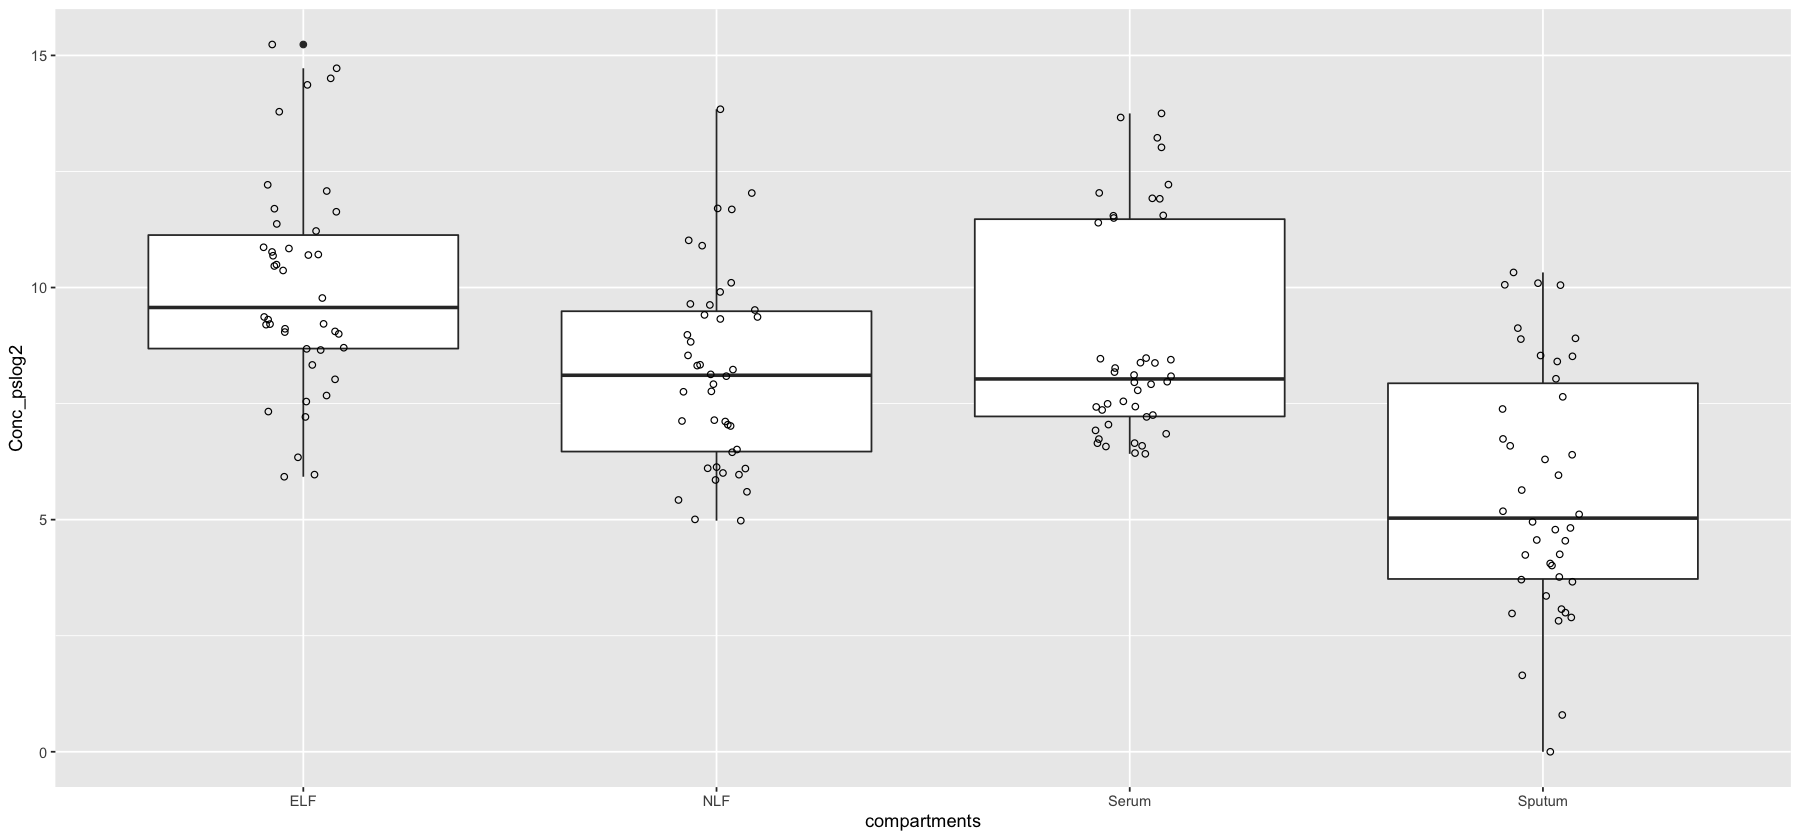

In [27]:
options(repr.plot.width=15, repr.plot.height=7)
#ordering Compartments based on median value
arranged_compartments_df = MIG_scaled_factored %>%
    group_by(Compartment) %>%
    summarize(median_concentration = median(Conc_pslog2)) %>%
    arrange(-median_concentration) %>%
    select(Compartment)

arranged_compartments = arranged_compartments_df$Compartment
compartments = factor(MIG_scaled_factored$Compartment, levels = arranged_compartments) #need to put descending_cytokines into a factor for plotting 
ggplot(MIG_scaled_factored, aes(x = compartments, y = Conc_pslog2)) +
  geom_boxplot() +
  geom_point(cex = 1.5, pch = 1.0,position = position_jitter(w = 0.1, h = 0)) 